Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for notMNIST_large. This may take a while. Please wait.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
Extracting data for notMNIST_small. This may take a while. Please wait.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [4]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),  # N x h x w 
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth   # Normalize pixels
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling notMNIST_large/A.pickle.
notMNIST_large/A
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling notMNIST_large/B.pickle.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756303
Standard deviation: 0.454491
Pickling notMNIST_large/C.pic

### Problem 1 - Display some sample image from a Folder

In [5]:
## Problem 1 --- Display some sample image from a Folder

import random
import hashlib
%matplotlib inline

In [8]:
## Display a Sample Image
def display_sample(data_folders, sample_size):
    """ Show a sample_size number of images from each of the data_folders """
    for folder in data_folders:
        print(folder)
        image_files = os.listdir(folder)
        image_sample = random.sample(image_files, sample_size)
        for img in image_sample:
            img_file = os.path.join(folder, img)
            display( Image(filename=img_file) )  # show the file using IPython.display

In [9]:
## Show training folders
display_sample(train_folders, 1)  # 1 sample image from each Training Folder

notMNIST_large/A


notMNIST_large/B


notMNIST_large/C


notMNIST_large/D


notMNIST_large/E


notMNIST_large/F


notMNIST_large/G


notMNIST_large/H


notMNIST_large/I


notMNIST_large/J


In [10]:
## Show test image samples
display_sample(test_folders, 1)

notMNIST_small/A


notMNIST_small/B


notMNIST_small/C


notMNIST_small/D


notMNIST_small/E


notMNIST_small/F


notMNIST_small/G


notMNIST_small/H


notMNIST_small/I


notMNIST_small/J


---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [11]:
# Show a subplot of 8 images
def display_image_titles(data_folders):
    """ Display upto 8 images from data folders """
    folder = random.sample(data_folders, 1)
    pickle_file = ''.join(folder) + '.pickle'
    try:
        with open(pickle_file, 'rb') as F:
            dataset = pickle.load(F)
    except Exception as e:
        print('Cannot read file ', pickle_file, ' Exception: ', e)
        return
    # show
    plt.suptitle(''.join(folder)[-1])
    for i, img in enumerate(random.sample( list(dataset), 8) ):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.imshow(img)

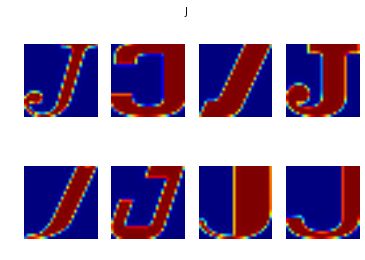

In [12]:
display_image_titles(train_folders)

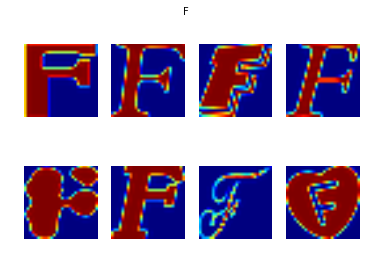

In [13]:
display_image_titles(test_folders)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [15]:
# Show number of images in each Training and Test dataset
def show_number_images(data_folders):
    for folder in data_folders:
        pickle_filename = ''.join(folder) + '.pickle'
        try:
            with open(pickle_filename, 'rb') as f:
                dataset = pickle.load(f)
        except Exception as e:
            print('Could not read: ', pickle_filename, ':', e)
            return
        print('Total images in', folder, ':', len(dataset))

show_number_images(train_folders)
show_number_images(test_folders)

Total images in notMNIST_large/A : 52909
Total images in notMNIST_large/B : 52911
Total images in notMNIST_large/C : 52912
Total images in notMNIST_large/D : 52911
Total images in notMNIST_large/E : 52912
Total images in notMNIST_large/F : 52912
Total images in notMNIST_large/G : 52912
Total images in notMNIST_large/H : 52912
Total images in notMNIST_large/I : 52912
Total images in notMNIST_large/J : 52911
Total images in notMNIST_small/A : 1872
Total images in notMNIST_small/B : 1873
Total images in notMNIST_small/C : 1873
Total images in notMNIST_small/D : 1873
Total images in notMNIST_small/E : 1873
Total images in notMNIST_small/F : 1872
Total images in notMNIST_small/G : 1872
Total images in notMNIST_small/H : 1872
Total images in notMNIST_small/I : 1872
Total images in notMNIST_small/J : 1872


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [16]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)  # shape = N x W x H 
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [17]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

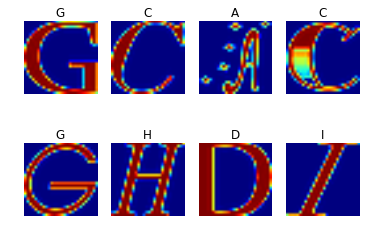

In [18]:
# Show sample dataset (with labels)

index_labels = {0: 'A', 1: 'B', 2: 'C', 3:'D', 4:'E',
               5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}

def show_sample_dataset(dataset, labels):
    items = random.sample(range(len(labels)), 8)
    for i, item in enumerate(items):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.title(index_labels[labels[item]])
        plt.imshow(dataset[item])

show_sample_dataset(train_dataset, train_labels)


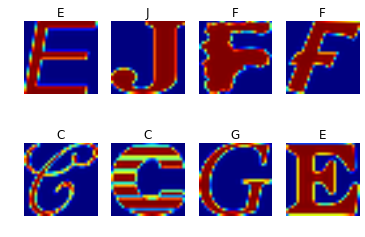

In [19]:
show_sample_dataset(test_dataset, test_labels)

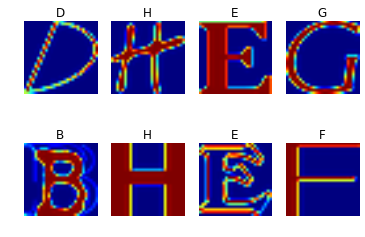

In [20]:
show_sample_dataset(valid_dataset, valid_labels)

Finally, let's save the data for later reuse:

In [21]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [22]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800503


In [23]:
print ('Train dataset: ', len(train_dataset))

Train dataset:  200000


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

### First - extract the overlap between two datasets
- Do it by nesting thru the datasets and comparing them

- Then, display the overlap



In [26]:
# Extract the overlap
def extract_overlap(dataset1, dataset2):
    overlap = {}
    for i, img1 in enumerate(dataset1):
        for j, img2 in enumerate(dataset2):
            if np.array_equal(img1, img2):
                if not i in overlap.keys():
                    overlap[i] = []  # save the index of overlapping images
                overlap[i].append(j)
    return overlap

In [51]:
# Show the overlap
def show_dataset_overlap(overlap, dataset1, dataset2):
    """ overlap is a dict of indexes that actually overlap between Dataset1 and Dataset2"""
    item = random.choice( list(overlap) )   # In Py3 use list() to get iterable keys
    print('Checking overlap for item: ', item)
    # grab 8 images to show
    images = np.concatenate( ( [dataset1[item]], dataset2[overlap[item][0:7] ] ) )
    plt.suptitle(item)
    for i, img in enumerate(images):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.imshow(img)

In [45]:
def display_overlap(overlap, source_dataset, target_dataset):
  item = random.choice( list(overlap) )
  imgs = np.concatenate(([source_dataset[item]], target_dataset[overlap[item][0:7]]))
  plt.suptitle(item)
  for i, img in enumerate(imgs):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(img)

In [30]:
# find the time taken to extract overlap
%time overlap_test_train = extract_overlap(test_dataset[:300], train_dataset)

CPU times: user 4min 45s, sys: 189 ms, total: 4min 46s
Wall time: 4min 46s


In [34]:
print(overlap_test_train)

{129: [165498], 130: [52064], 131: [65121], 69: [139511], 289: [30024], 200: [43], 11: [118818, 183654], 288: [136307, 166886], 77: [17647], 15: [156759], 17: [174599], 227: [35250], 173: [177329], 240: [144280], 153: [18240, 91361, 195452], 26: [38364], 155: [128, 235, 242, 290, 303, 490, 522, 623, 634, 668, 669, 951, 984, 999, 1001, 1080, 1361, 1431, 1560, 1871, 1933, 2021, 2129, 2192, 2261, 2303, 2499, 2513, 2583, 2643, 2733, 3070, 3165, 3169, 3217, 3254, 3344, 3346, 3556, 3786, 3984, 4038, 4277, 4424, 4425, 4706, 4730, 4935, 4946, 5017, 5193, 5194, 5245, 5325, 5380, 5463, 5476, 5496, 5509, 5518, 5532, 5695, 5719, 5762, 5775, 5852, 5878, 5910, 6008, 6092, 6139, 6458, 6499, 6502, 6519, 6538, 6580, 6618, 6623, 6680, 6711, 6754, 6769, 6872, 7037, 7092, 7570, 7602, 7907, 7983, 8028, 8085, 8108, 8123, 8279, 8290, 8397, 8462, 8512, 8531, 8876, 8924, 8955, 8984, 8986, 9164, 9169, 9181, 9423, 9443, 9479, 9509, 9540, 9541, 9606, 9637, 9869, 9968, 10053, 10221, 10339, 10498, 10547, 10665, 107

In [35]:
for i in overlap_test_train.keys():
    print(i, len(overlap_test_train[i]))

129 1
130 1
131 1
69 1
289 1
200 1
11 2
288 2
77 1
15 1
17 1
227 1
173 1
240 1
153 3
26 1
155 2178
28 1
250 1
30 2
165 1
237 1
33 1
162 1
91 1
228 1
101 1
220 1
234 2
235 1
109 1
238 3
176 1
264 4
261 1
248 1
121 1
122 1
125 2178


Number of overlap:  39
Checking overlap for item:  162


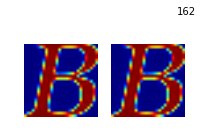

In [41]:
print('Number of overlap: ', len(overlap_test_train.keys()))
show_dataset_overlap(overlap_test_train, test_dataset[:300], train_dataset)

### Use Manhattan distance (abs value) for image similarity 
- instead of actual pixel values, use manhattan distance

In [43]:
# use Manhattan distance (abs value difference) to calc image similarity
MAX_MANHATTAN_DIST = 10

def extract_overlap_manhattan(dataset1, dataset2):
    overlap = {}
    for i, img1 in enumerate(dataset1):
        for j, img2 in enumerate(dataset2):
            diff = img1 - img2
            m_norm = np.sum( np.abs(diff) )
            if m_norm < MAX_MANHATTAN_DIST:
                if not i in overlap.keys():
                    overlap[i] = []   # save the source index
                overlap[i].append(j)  # save the target index
    return overlap

In [44]:
%time overlap_test_train_manhattan = extract_overlap_manhattan(test_dataset[:300], train_dataset)

CPU times: user 7min 37s, sys: 409 ms, total: 7min 38s
Wall time: 7min 38s


Number of overlap:  78
Checking overlap for item:  200


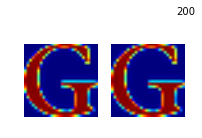

In [46]:
print('Number of overlap: ', len(overlap_test_train_manhattan.keys()))
show_dataset_overlap(overlap_test_train_manhattan, test_dataset[:300], train_dataset)

### To perform at scale, extract overlap using hash functions


In [47]:
# Extract overlap using Hash functions
def extract_overlap_hash(dataset1, dataset2):
    hash_dataset1 = [hashlib.sha256(img).hexdigest() for img in dataset1 ]
    hash_dataset2 = [hashlib.sha256(img).hexdigest() for img in dataset2 ]
    overlap = {}
    for i, h1 in enumerate(hash_dataset1):
        for j, h2 in enumerate(hash_dataset2):
            if h1 == h2:
                if not i in overlap.keys():
                    overlap[i] = []   # save the source index
                overlap[i].append(j)  # save the target indices (that match)
    return overlap

In [48]:
%time overlap_test_train_hash = extract_overlap_hash(test_dataset[:300], train_dataset)


CPU times: user 6.05 s, sys: 16.4 ms, total: 6.07 s
Wall time: 6.07 s


Number of overlap:  39
Checking overlap for item:  220


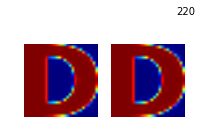

In [56]:
print('Number of overlap: ', len(overlap_test_train_hash.keys()))
show_dataset_overlap(overlap_test_train_hash, test_dataset[:300], train_dataset)

In [57]:
# Use np.where to find duplicates -- make it slightly faster
def extract_overlap_hash_where(dataset1, dataset2):
    hash_dataset1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset1 ])
    hash_dataset2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset2 ])
    overlap = {}
    for i, hash1 in enumerate(hash_dataset1):
        duplicates = np.where( hash_dataset2 == hash1 )
        if len(duplicates[0]):
            overlap[i] = duplicates[0]
    return overlap

In [58]:
%time overlap_test_train_where = extract_overlap_hash_where(test_dataset[:300], train_dataset)

CPU times: user 2.89 s, sys: 48.7 ms, total: 2.94 s
Wall time: 2.94 s


Number of overlaps: 39


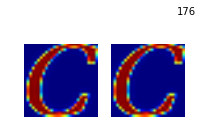

In [61]:
print('Number of overlaps:', len(overlap_test_train_where.keys()))
display_overlap(overlap_test_train_where, test_dataset[:300], train_dataset)

### Now sanitize the dataset to remove duplicates or near duplicates



In [64]:
# sanitize the dataset to remove dups or near dups
def sanitize_duplicates(dataset1, dataset2, labels1):
    hash_dataset1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset1 ])
    hash_dataset2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset2 ])
    overlap = [] # list of indices
    for i, hash1 in enumerate(hash_dataset1):
        duplicates = np.where( hash_dataset2 == hash1 )
        if len(duplicates[0]):
            overlap.append(i)
    return np.delete(dataset1, overlap, 0), np.delete(labels1, overlap, None)

In [65]:
%time test_dataset_sane, test_labels_sane = sanitize_duplicates(test_dataset[:300], train_dataset, test_labels[:300])

CPU times: user 2.95 s, sys: 44.7 ms, total: 3 s
Wall time: 3 s


In [67]:
print('Overlapping values removed: ', len(test_dataset[:300]) - len(test_dataset_sane))

Overlapping values removed:  39


In [68]:
### same number of values are removed. Now go ahead and clean the whole datasets

In [72]:
%time valid_dataset_sane, valid_labels_sane = sanitize_duplicates(valid_dataset, train_dataset, valid_labels)
print('Overlap removed from Validation: ', len(valid_dataset) - len(valid_dataset_sane))

CPU times: user 34.9 s, sys: 87.5 ms, total: 35 s
Wall time: 35 s
Overlap removed from Validation:  1067


In [73]:
%time test_dataset_sane, test_labels_sane = sanitize_duplicates(test_dataset, train_dataset, test_labels)
print('Overlap removed from Test: ', len(test_dataset) - len(test_dataset_sane))

CPU times: user 34.9 s, sys: 132 ms, total: 35 s
Wall time: 35.1 s
Overlap removed from Test:  1324


In [74]:
## Now save the Sanitized datasets in a pickle file
pickle_file = 'notMNIST_sanitized.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset_sane,
    'valid_labels': valid_labels_sane,
    'test_dataset': test_dataset_sane,
    'test_labels': test_labels_sane,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [76]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 683292763




---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

### Currently using only (non-sanitized) datasets

In [77]:
clf = LogisticRegression()
X_test = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
y_test = test_labels

In [78]:
# Test 1: n=50
sample_size = 50
X_train = train_dataset[:sample_size].reshape(sample_size, 28 * 28)
y_train = train_labels[:sample_size]
# Fit the model
%time clf.fit(X_train, y_train)
# get the scores
clf.score(X_test, y_test)

CPU times: user 42.2 ms, sys: 2.65 ms, total: 44.8 ms
Wall time: 51.5 ms


0.50900000000000001

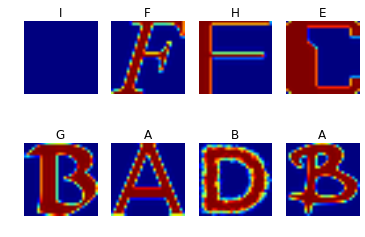

In [79]:
pred_labels = clf.predict(X_test)
show_sample_dataset(test_dataset, pred_labels)

In [81]:
# Test 2: n=100
sample_size = 100
X_train = train_dataset[:sample_size].reshape(sample_size, 28 * 28)
y_train = train_labels[:sample_size]
# Fit the model
%time clf.fit(X_train, y_train)
# get the scores
print('For', sample_size, ' samples, score: ', clf.score(X_test, y_test) )

CPU times: user 109 ms, sys: 1.77 ms, total: 111 ms
Wall time: 112 ms
For 100  samples, score:  0.6966


In [82]:
# Test 3: n=1000
sample_size = 1000
X_train = train_dataset[:sample_size].reshape(sample_size, 28 * 28)
y_train = train_labels[:sample_size]
# Fit the model
%time clf.fit(X_train, y_train)
# get the scores
print('For', sample_size, ' samples, score: ', clf.score(X_test, y_test) )

CPU times: user 2 s, sys: 10.1 ms, total: 2.01 s
Wall time: 2.02 s
For 1000  samples, score:  0.8333


In [83]:
# Test 4: n=5000
sample_size = 5000
X_train = train_dataset[:sample_size].reshape(sample_size, 28 * 28)
y_train = train_labels[:sample_size]
# Fit the model
%time clf.fit(X_train, y_train)
# get the scores
print('For', sample_size, ' samples, score: ', clf.score(X_test, y_test) )

CPU times: user 16.7 s, sys: 42 ms, total: 16.7 s
Wall time: 16.8 s
For 5000  samples, score:  0.8511


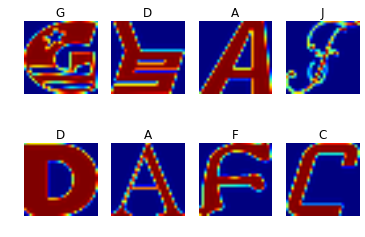

In [84]:
# Lets see what we got as predictions
pred_labels = clf.predict(X_test)
show_sample_dataset(test_dataset, pred_labels)

### for the whole dataset, use another solver 

In [85]:
clf = LogisticRegression(solver='sag')   # use the SAG solver
sample_size = len(train_dataset)
X_train = train_dataset[:sample_size].reshape(sample_size, 28 * 28)
y_train = train_labels[:sample_size]
# Fit the model
%time clf.fit(X_train, y_train)
# get the scores
print('For', sample_size, ' samples, score: ', clf.score(X_test, y_test) )

CPU times: user 8min 33s, sys: 837 ms, total: 8min 34s
Wall time: 8min 34s
For 200000  samples, score:  0.8932


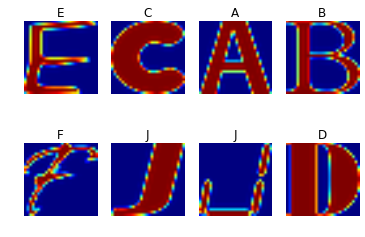

In [86]:
# Lets see what we got as predictions
pred_labels = clf.predict(X_test)
show_sample_dataset(test_dataset, pred_labels)